# Tutorial on how to use tpmpy toolbox

### Step 0: Key imports...

In [1]:
import numpy as np
from numpy.linalg import pinv
from tensorlib.tucker import hosvd
from tensorlib import dtensor, unfolded_dtensor
from tensorlib.tpconvex import to_cno, to_irno
from tensorlib.grid import coordinate_grid, map_points_to_grid
from tensorlib.draw import draw_weighting_system
from tensorlib.inference import reconstruct, infer_ats, rulify, infer_from_ruleset, genetic_algo_rulify
from tensorlib.metrics import calc_R2, calc_nRMSE_maxmin, calc_nRMSE_iqr, calc_cindex
from functools import reduce

###############################################
## Constants, file paths
###############################################
CSVFILE = "./app_data_demo/data.csv"
DATAFILE = "./app_data_demo/data.txt"
AGGREGATED_VALUES_FILE = "./app_data_demo/data.npy"

### Step 1: read the data from file or elsewhere

In [2]:
import pandas as pd

df = pd.read_csv(CSVFILE, delimiter=',', encoding='utf-8')

## you can keep only a subset of columns if you want...
##df = df[[input1', 'outputcol']]

cols_to_export = ['input1', 'input2', 'outputcol']
df[cols_to_export].to_csv(DATAFILE, sep=' ', header=False, index=False)

print(f"Number of rows in final dataset: {len(df)}")
df.head()


Number of rows in final dataset: 15


,input1,input2,outputcol
0,8,5,69
1,12,4,4
2,2,9,13
3,3,3,12
4,1,9,10


In [3]:
df.describe() ## stats on columns

,input1,input2,outputcol
count,15.000000,15.000000,15.000000
mean,8.600000,7.200000,59.266667
std,6.400893,6.270111,112.262745
min,0.000000,0.000000,-18.000000
25%,2.500000,3.000000,5.000000
50%,9.000000,5.000000,13.000000
75%,12.500000,9.000000,46.000000
max,19.000000,19.000000,342.000000


### Step 2: Create discretization grid

### Explanation on coordinate grid

To do TP modeling, we need an N-dimensional grid of coordinates.<br>
In our case, we have 2 input dimensions and 1 output dimension. So our grid will be 2-dimensional.<br>

Each of the dimensions ranges from a minimum to a maximum value, at a pre-determined (or indeed variable) step size.<br>

One way to create the grid would be by listing all coordinates in all dimensions. If we had regular step intervals, and a large number of coordinates, we could also use the create_from_polyranges constructor.

But in our case, we will choose a different path. **The idea is that we want to try many different gridding alternatives and find the best reconstruction over all of them, using a genetic algorithm.**

In [4]:
arr = np.loadtxt(DATAFILE)
data = dtensor(arr)
data[:5, :] ## first 5 rows

dtensor([[ 8.,  5., 69.],
         [12.,  4.,  4.],
         [ 2.,  9., 13.],
         [ 3.,  3., 12.],
         [ 1.,  9., 10.]])

In [5]:
dim_names=['input1', 'input2'] ## outputcol is skipped because that's an output

In [6]:
## this is the genetic algorithm:
## see df.describe above. Minimum is 0 or 1 and maximum is 19
gen_algo = coordinate_grid.genetic_algo_search_for_coordinates_r2(data, [(0, 19), (0, 19)], population_sz=35, num_generations=10)

Generation 1 [#################################################>] 100% | Elapsed: 00h 00m 01s | Remaining: 00h 00m 00s
	Validation error for top-top entity so far: 0.9219690492628195
	... with params [[0.03631245453381874, 0.44053097730467333, 0.8107334861672497, 0.9761622277172738, 0.9882536387332095], [0.3659334974329411, 0.5667849155490333, 0.6370257475988226, 0.8175116395048945], (0, 19), (0, 19), 'closest', 6]
Generation 2 [#################################################>] 100% | Elapsed: 00h 00m 00s | Remaining: 00h 00m 00s
	Validation error for top-top entity so far: 0.9349660941423922, because old < new: True
	... with params [[0.36545393002185234, 0.40936468890699507, 0.5174025935111154, 0.9760009510194252, 0.9860009510194252], [0.11645662683818947, 0.641249270138704, 0.7623576779878691, 0.9191591966467683, 0.9291591966467683], (0, 19), (0, 19), 'wsum', 9]
Generation 3 [#################################################>] 100% | Elapsed: 00h 00m 00s | Remaining: 00h 00m 00s
	

In [7]:
## note that "Validation error" is in fact the R2 score between the reconstructed and original data
## so, a higher validation error is better
## we can see the results on the best entity found above, however, we
## can also retrieve all information from the returned object, gen_algo:
print(f"fitness: {gen_algo.top_top_entity.get_fitness()}")
print(f"phenotype: {gen_algo.top_top_entity.get_phenotype()}")


fitness: 0.9787063244176616
phenotype: [[0.15927967954507127, 0.4814132401023999, 0.6340150371849861, 0.7653186779958969, 0.840801819541318], [0.07686703705344372, 0.5647992406529505, 0.9227128360732577, 0.9627330392574984, 0.9775953768415099], (0, 19), (0, 19), 'closest', 5]


### Based on the above, we can use the create_from_ranges_and_positions_as_percentages constructor to create the grid that was found to be optimal

In [8]:
mygrid = coordinate_grid.create_from_ranges_and_positions_as_percentages(
    [(0, 19), (0, 19)],
    [
        [0.15927967954507127, 0.4814132401023999, 0.6340150371849861, 0.7653186779958969, 0.840801819541318],
        [0.07686703705344372, 0.5647992406529505, 0.9227128360732577, 0.9627330392574984, 0.9775953768415099]
    ],
    dim_names=dim_names)

print("Coordinates per dimension:")
for inx, dim in enumerate(mygrid.get_coords_per_dim()):
    print(f"{dim_names[inx]}:")
    print(dim)
    print(f"{len(dim)} coordinates", end="\n\n")

Coordinates per dimension:
input1:
(3.026313911356354, 9.146851561945597, 12.046285706514736, 14.541054881922042, 15.975234571285043)
5 coordinates

input2:
(1.4604737040154308, 10.73118557240606, 17.531543885391898, 18.29192774589247, 18.574312159988686)
5 coordinates



### Next, we load the data, convert it to a dense tensor (dtensor) and map it onto the coordinate grid. To do this:
- First, we associate each data point with the closest grid point (in Euclidean terms). These are referred to as 'primary associations'
- In case there are grid points that do not have at least Pc data points associated with them, we select as many further data points that are closest to those grid points as necessary (these data points may then be associated with more then 1 grid point - through a primary association and one or more secondary associations)
- Next, we aggregate the output value of each data point associated with each grid point, to get the aggregates tensor (by taking the mean, median or weighted sum of the output values, or by taking the output value of the closest data point). We also get back a counts tensor, which reveals the number of primary associations at each grid point

In [9]:
arr = np.loadtxt(DATAFILE)
data = dtensor(arr)
data[:5, :]

dtensor([[ 8.,  5., 69.],
         [12.,  4.,  4.],
         [ 2.,  9., 13.],
         [ 3.,  3., 12.],
         [ 1.,  9., 10.]])

In [10]:
## Recall that from the genetic algorithm, the output said 'closest' and 'Pc=5'

aggs, counts = map_points_to_grid(data, mygrid, agg='closest', Pc=5) ## can be closest, mean, median or wsum
aggs_filled = np.nan_to_num(aggs, nan=0) ## now, because the frequency of some gridpoints is 0, we need to fill the nans with zeros
aggregates = dtensor(aggs_filled)
print(data.shape)
print(counts.shape)

Bucketing all datapoints by gridpoint based on primary associations [#################################################>] 100% | Elapsed: 00h 00m 00s | Remaining: 00h 00m 00s
Bucket further datapoints by gridpoint based on secondary associations (where necessary) [#################################################>] 100% | Elapsed: 00h 00m 00s | Remaining: 00h 00m 00s
Aggregate [#################################################>] 100% | Elapsed: 00h 00m 00s | Remaining: 00h 00m 00s
(15, 3)
(5, 5)


### ... and here are some ways in which you can interact with mygrid, counts and aggregates

In [11]:
## Random sampling from any numpy ndarray
def sample_from_ndarr(arr, k=1):
    """
    Samples k items from arr and also returns the coordinates of the samples
    """
    flat_indices = np.random.choice(arr.size, size=k, replace=False) ## flattened indices
    multi_indices = np.array(np.unravel_index(flat_indices, arr.shape)).T ## convert to n-dimensional indices
    values = arr[np.unravel_index(flat_indices, arr.shape)] ## get the values

    return (values, multi_indices)

In [12]:
samples, indices = sample_from_ndarr(mygrid.get_grid_with_coords(), 1)

indices = indices[0][:-1]

print(f"Sample coordinate: {samples[0]} - at indices: {indices}")
print(f"Count for coordinate: {counts[*indices]}")
print(f"Aggregate for coordinate: {aggregates[*indices]}")
print(f"shape of each data structure: {mygrid.get_grid_with_coords().shape}, {counts.shape}, {aggregates.shape}")
print(f"Sum of all counts: {np.ravel(counts).std()}")

Sample coordinate: 14.541054881922042 - at indices: [3 1]
Count for coordinate: 0
Aggregate for coordinate: 23.0
shape of each data structure: (5, 5, 2), (5, 5), (5, 5)
Sum of all counts: 0.938083151964686


### Recall that mygrid is a 4-by-5 grid. Each data point in the data tensor has now been associated with 1 (or more, if needed) grid point, and all data points at each grid point have been aggregated by choosing the closest data point and using its output as the 'value' of the grid point. This is what 'aggregates' represents: it is a 2-D tensor, such that each value is the output value of the data point that is closest to the given grid point...

### Since the grid can be quite big, you might want to persist the aggregated values...

In [13]:
np.save(AGGREGATED_VALUES_FILE, aggs_filled)

In [14]:
## you can re-load them like this:
aggregates = dtensor(np.load(AGGREGATED_VALUES_FILE))

### Next, we will perform HOSVD. When the program asks us how many eigenvalues we want to keep, let's type 2 (as long as there are at least 2 singular values in each dimension) and then hit Enter

In [15]:
Us, S = hosvd(aggregates)
print(f"Singular values are: {np.diag(S)}")
rank_to_keep = int(input("How many singular values do you want to keep?"))

print(f"Keeping {rank_to_keep} singular values")

Us_tilde, S_tilde = hosvd(aggregates, rank=[rank_to_keep]*aggregates.ndim)

reconstructed = reconstruct(S_tilde, Us_tilde)
rmse_reconstruction = np.sqrt(np.mean((reconstructed - aggregates)**2))

r2_reconstruction = calc_R2(aggregates, reconstructed)
print(f"Reconstruction R2 is: {r2_reconstruction}")

data_reconstructed = infer_ats(S_tilde, Us_tilde, mygrid, data[:,:2])

r2_dataset = calc_R2(data[:, -1].reshape(-1,1), data_reconstructed)
print(f"R2 on original data is: {r2_dataset}")


Singular values are: [ 1.1321587e+03  8.7213631e+01 -1.8465481e+01  4.0424681e+00
 -1.3663737e-11]


How many singular values do you want to keep? 2


Keeping 2 singular values
Reconstruction R2 is: 0.999387264251709
R2 on original data is: 0.9739854322092256


In [16]:
S_cno, Us_cno = to_cno(S_tilde, Us_tilde)

Distance from NO: 0.1337849259028116
Distance from NO: 1.4191694954546514


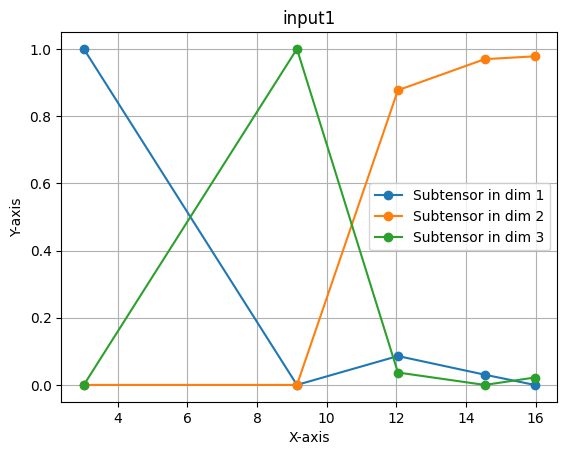

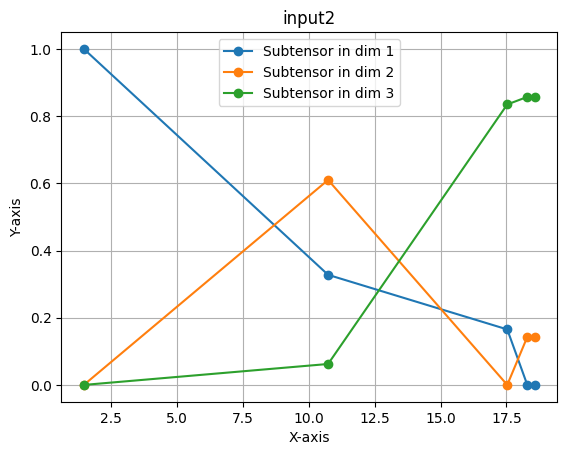

In [17]:
draw_weighting_system(Us_cno, mygrid)

In [18]:
S_irno, Us_irno = to_irno(S_tilde, Us_tilde)

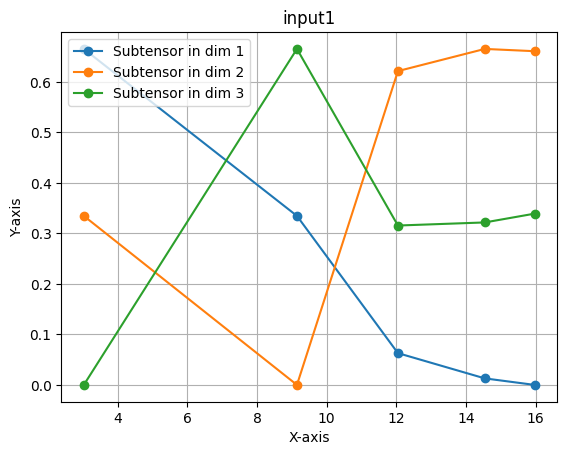

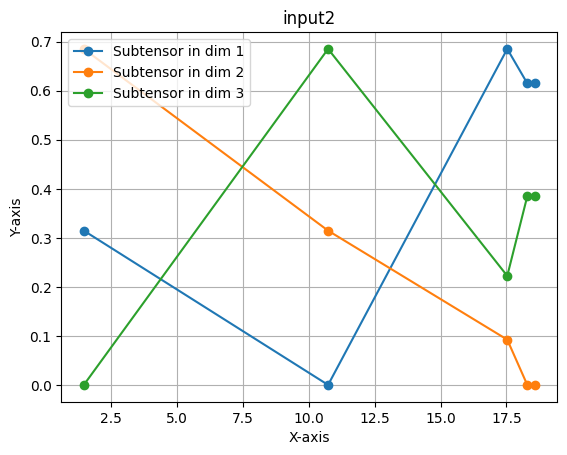

In [19]:
draw_weighting_system(Us_irno, mygrid)

In [20]:
print(f"inference at random point using CNO system:\n {infer_ats(S_cno, Us_cno, mygrid, np.array([[2, 5], [11, 5.5]]))}")
print(f"inference at random point using IRNO system:\n {infer_ats(S_irno, Us_irno, mygrid, np.array([[2, 5], [11, 5.5]]))}")

inference at random point using CNO system:
 [[ 1.44573836]
 [32.92955745]]
inference at random point using IRNO system:
 [[ 1.44573836]
 [32.92955745]]


In [21]:
print(f"Whereas the original system yields these results:\n {infer_ats(S, Us, mygrid, np.array([[2, 5], [11, 5.5]]))}")

Whereas the original system yields these results:
 [[ 1.64389605]
 [32.66613193]]


# Based on the above, we can already see what ranges of the different input dimensions are unique and separate from each other. Based on this, we can now generate a set of weighted rules

### Step 3: Rule generation

#### Since there are quite a few hyperparameters, like support length to use, alpha-cut to use and maximum antecedent variables per input dimension, we can use a genetic algorithm again to find the rule set that can be best used to reconstruct the original data

In [22]:
ga = genetic_algo_rulify(S_cno, Us_cno, mygrid, counts, data, population_sz=25, num_generations=10, dict_of_params={
    'min_wfun_val_ab': (0.5, 0.95), ## minimum alpha cut sampled from this range
    'min_rule_weight_ab': (0.001, 0.005), ## minimum rule representation sampled from this range
    'num_samples_ab': (1,4), ## number of samples used to generate rules sampled from this range
    'max_antecedent_nums_ab_per_dim': [(2,5), (2,5)], ## maximum number of antecedent vars per dimension sampled from these ranges
    'num_trials_to_aggregate': 5,
    'pct_data_points_ab': (0.1, 0.5) ## percentage of data points considered
})

Generation 1 [#################################################>] 100% | Elapsed: 00h 00m 00s | Remaining: 00h 00m 00s
	Validation error for top-top entity so far: 0.9398715343834265
	... with params min wf val: 0.5465813502435861; min rule w: 0.0030715645425367435; max num of antecedents: [5, 2]; samples for creating rules: 4; pct of datapts: 0.3984306189718638; datapts considered: [14 13  9  7  0]; antecedent ranges: [[(np.float64(-0.1), np.float64(2.1)), (np.float64(7.9), np.float64(9.1)), (np.float64(18.9), np.float64(19.1))], [(np.float64(-0.1), np.float64(6.1)), (np.float64(17.9), np.float64(18.1))]]
Generation 2 [#################################################>] 100% | Elapsed: 00h 00m 00s | Remaining: 00h 00m 00s
	Validation error for top-top entity so far: 0.9575448737613352, because old < new: True
	... with params min wf val: 0.607262887843627; min rule w: 0.001955077336170778; max num of antecedents: [5, 5]; samples for creating rules: 2; pct of datapts: 0.205216733098856

In [23]:
min_weighting_func_val = ga.top_top_entity.get_phenotype()[0]
min_rule_weight = ga.top_top_entity.get_phenotype()[1]
samples_consequents = ga.top_top_entity.get_phenotype()[2]
max_antecedent_nums = ga.top_top_entity.get_phenotype()[3]
indices = ga.top_top_entity.get_phenotype()[4]
antecedent_ranges = ga.top_top_entity.get_phenotype()[5]
rules = ga.top_top_entity.get_phenotype()[6]

print(min_weighting_func_val)
print(min_rule_weight)
print(samples_consequents)
print(max_antecedent_nums)
print(indices)
print()
print("antecedent ranges:")
for dim in antecedent_ranges:
    print(dim)
print()
print(rules)

0.7737016143899422
0.0012027024769374784
3
[5, 3]
[13  5 12  3  0]

antecedent ranges:
[(np.float64(2.9), np.float64(3.1)), (np.float64(7.9), np.float64(9.1)), (np.float64(14.9), np.float64(15.1))]
[(np.float64(-0.1), np.float64(3.1)), (np.float64(17.9), np.float64(18.1))]

0 AND 0 => 14.27 (weight: 0.2000)
1 AND 0 => 58.43 (weight: 0.1333)
0 AND 1 => 31.73 (weight: 0.0667)
1 AND 1 => 314.48 (weight: 0.0667)
2 AND 0 => 5.58 (weight: 0.0667)
2 AND 1 => 339.71 (weight: 0.0000)

Total number of rules: 6

Sum of all weights: 0.5333333333333333


In [24]:
data_reconstructed = infer_from_ruleset(rules, data[:,:-1], cutoff_weight=min_rule_weight)
r2_dataset = calc_R2(data[:, -1].reshape(-1,1), data_reconstructed)
print(f"R2 score: {r2_dataset}")

R2 score: 0.9848715331869571


In [25]:
CSV_WITH_TP_RULES = "./app_data_demo/rules001.csv"

In [26]:
rules.to_csv(min_weight=0.0000001, filename=CSV_WITH_TP_RULES)